In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import gc
from functools import partial
import time
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.linalg
import copy
import sklearn
import rastermap
import pandas as pd
from tqdm.notebook import tqdm

import tensorly as tl
import tensorly.decomposition
import torch

In [3]:
# import sys
# sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from bnpm import torch_helpers, file_helpers, timeSeries, ca2p_preprocessing, welford_moving_2D, linear_regression, similarity, spectral, featurization, decomposition, h5_handling, math_functions

%load_ext autoreload
%autoreload 2
import roicat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%load_ext autoreload
%autoreload 2
import bmi_idap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
params = {}
results = {}

In [6]:
params['paths'] = {}

# params['paths']['dir_analysisFiles'] = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_2_6').resolve())
# params['paths']['dir_analysisFiles'] = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_1511L').resolve())
# params['paths']['dir_analysisFiles'] = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_g8test/').resolve())
params['paths']['dir_analysisFiles'] = str(Path(r'D:\RH_local\data\BMI_cage_g8Test\mouse_g8t\analysis_data').resolve())

## Directory with F.npy, stat.npy etc.
# params['paths']['dir_s2p']   = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_2_6/statFiles/20210409').resolve())
# params['paths']['dir_s2p']     = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_1511L/statFiles/20230111').resolve())
# params['paths']['dir_s2p']   = str(Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_g8test/mouse_g8t/jobNum_0/suite2p/plane0').resolve())
params['paths']['dir_s2p']   = str(Path(r'D:\RH_local\data\BMI_cage_g8Test\mouse_g8t\suite2p\plane0').resolve())

## Path of iscell. Can be from neural net output (iscell_NN)
params['paths']['path_iscell'] = str(Path(params['paths']['dir_analysisFiles']) / 'iscell_NN_tqm.npy')

## Path of tqm (trace quality metrics). Used to get dFoF parameters
params['paths']['path_tqm'] = str(Path(params['paths']['dir_analysisFiles']) / 'trace_quality.pkl')


params['paths']['dir_save']       =  copy.copy(params['paths']['dir_analysisFiles'])
params['paths']['path_save_weights'] = str(Path(params['paths']['dir_save']) / 'weights_day0')
params['paths']['path_save_results'] = str(Path(params['paths']['dir_save']) / 'decoder_definition')

In [7]:
results['general'] = {}

results['general']['datetime'] = str(datetime.datetime.now())
results['general']['cwd'] = os.getcwd()

In [8]:
params['general'] = {}

params['general']['use_gpu'] = True

In [9]:
device = torch_helpers.set_device(use_GPU=params['general']['use_gpu'])

results['device'] = device

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11264MB, multi_processor_count=68)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11264MB, multi_processor_count=68)


In [10]:
iscell = np.load(params['paths']['path_iscell'])
tqm = file_helpers.pickle_load(params['paths']['path_tqm'])

In [11]:
## == IMPORT DATA ==
F, Fneu, iscell_s2p, ops, spks_s2p, stat = ca2p_preprocessing.import_s2p(params['paths']['dir_s2p'])
n_frames, n_rois = F.shape[1], F.shape[0]
Fs = ops['fs']

In [12]:
frame_height, frame_width = ops['meanImg'].shape[0], ops['meanImg'].shape[1]

# sf = import_and_convert_to_CellReg_spatialFootprints([dir_s2p / 'stat.npy'], frame_height=frame_height, frame_width=frame_width, dtype=np.float32)[0]

data_rois = roicat.data_importing.Data_suite2p([str(Path(params['paths']['dir_s2p']) / 'stat.npy')], FOV_height_width=(frame_height, frame_width))
sf = data_rois.spatialFootprints[0]

Completed: Set FOV_height and FOV_width successfully.
Importing spatial footprints from stat files.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


Imported 1 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 1 sessions successfully.
Completed: Created sessionID_concat.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


In [13]:
results['data'] = {}

results['data']['data'] = n_frames
results['data']['n_rois'] = n_rois
results['data']['Fs'] = Fs
results['data']['frame_height'] = frame_height
results['data']['frame_width'] = frame_width
results['data']['spatialFootprints'] = sf
results['data']['iscell'] = iscell

# Prepare dFoF

In [14]:
idx_time_bad = np.arange(0,0)

idx_time_good = np.arange(n_frames)[~np.isin(np.arange(n_frames), idx_time_bad)]

In [15]:
results['idx_time_bad'] = idx_time_bad

In [16]:
F_toUse = F[iscell][:, idx_time_good]
Fneu_toUse = Fneu[iscell][:, idx_time_good]

In [17]:
params['dFoF'] = {}

params['dFoF']['channelOffset_correction'] = tqm['dFoF_params']['channelOffset_correction']
params['dFoF']['percentile_baseline'] = tqm['dFoF_params']['percentile_baseline']
params['dFoF']['neuropil_fraction'] = tqm['dFoF_params']['neuropil_fraction']
params['dFoF']['win_rolling_percentile'] = 10*60*30  ## In frames

In [18]:
# dFoF with reduced percentile for baseline

dFoF, dF, F_neuSub, F_baseline = ca2p_preprocessing.make_dFoF(
    F=F_toUse,
    Fneu=Fneu_toUse,
    neuropil_fraction=params['dFoF']['neuropil_fraction'],
    percentile_baseline=params['dFoF']['percentile_baseline'],
    rolling_percentile_window=params['dFoF']['win_rolling_percentile'],
    channelOffset_correction=params['dFoF']['channelOffset_correction'],
    multicore_pref=True,
    verbose=True
)
# # Threshold for nonnegativity
# dFoF_z = dFoF / np.std(dFoF,axis=1,keepdims=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


Calculated dFoF. Total elapsed time: 16.98 seconds


In [19]:
np.sum(dFoF > 30)

0

In [20]:
# dFoF = np.nan_to_num(dFoF)

### Look at rastermap

In [21]:
import rastermap

In [22]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [23]:
# X = scipy.stats.zscore(dFoF, axis=0).T
# X = scipy.stats.zscore(dFoF, axis=1)
# X = dFoF / np.std(dFoF, axis=1, keepdims=True)
X = dFoF.copy()
rmap.fit(X)

nmin 200
0.09176325798034668
2.761194944381714
2.871875047683716
2.8738696575164795
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.29s     0        0.1407      2
0.32s    10        0.2829      4
0.35s    20        0.2958      8
0.38s    30        0.3332      18
0.41s    40        0.3663      28
0.44s    50        0.3965      38
0.47s    60        0.4014      38
0.50s   final      0.4022
0.50s upsampled    0.4022


<IPython.core.display.Javascript object>


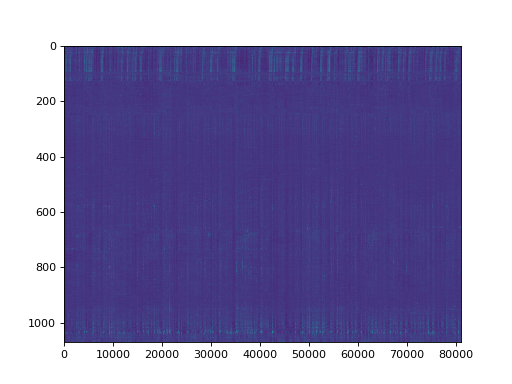

In [24]:
%matplotlib notebook

plt.figure()
plt.imshow(X[rmap.isort], aspect='auto', vmin=-0.5, vmax=3)

# Pre-orthogonalization

### Define traces to orthogonalize out:
- Mean neuron trace (average vector)
    - multiple frequency components
- Mean neuropil trace
    - multiple frequency components

In [39]:
params['preorthogonalization'] = {}

params['preorthogonalization']['bandpass_freqs_boundaries'] = [0, 1/(60*5), 1/20, 1/2, 5, np.inf]
params['preorthogonalization']['mspline_grid_order'] = 3
params['preorthogonalization']['mspline_grid_numSplines'] = 4
params['preorthogonalization']['num_taps'] = 10001
params['preorthogonalization']['window'] = ('kaiser', 3.0)

In [40]:
dFoF_mean = np.nanmean(dFoF, axis=0)
Fneu_mean = np.nanmean(Fneu_toUse, axis=0)

<IPython.core.display.Javascript object>


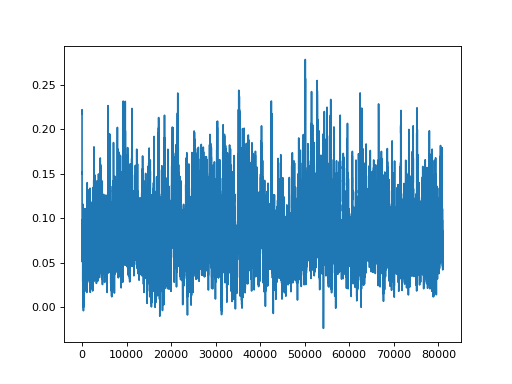

<IPython.core.display.Javascript object>


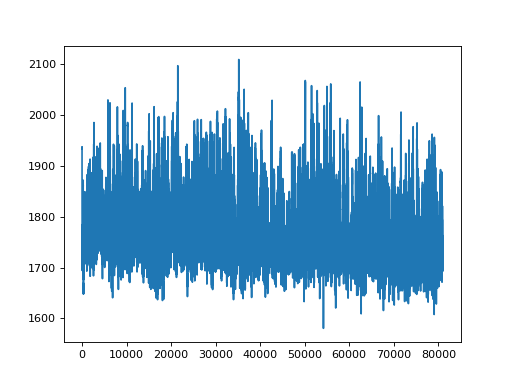

In [41]:
plt.figure()
plt.plot(dFoF_mean)

plt.figure()
plt.plot(Fneu_mean)

### spectral expansion

Make a set of band pass filter, then filter traces with each filter

In [42]:
bpfb = params['preorthogonalization']['bandpass_freqs_boundaries'] 

bandpass_ab = [spectral.design_fir_bandpass(bp_1, bp_2, num_taps=params['preorthogonalization']['num_taps'], fs=Fs, window=params['preorthogonalization']['window'], plot_pref=False) for ii, (bp_1, bp_2) in enumerate(zip(bpfb[:-1], bpfb[1:]))]

In [43]:
traces = [spectral.plot_digital_filter_response(b=h, fs=Fs, worN=100000, plot_pref=False) for h in tqdm(bandpass_ab)]

  0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


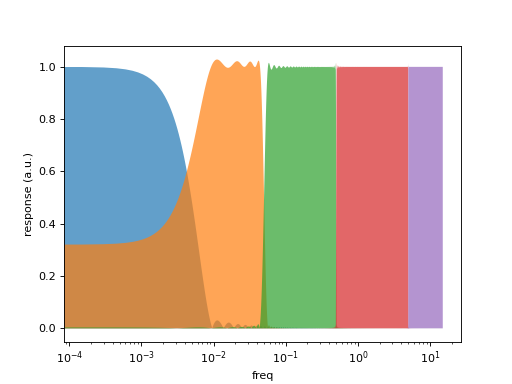

In [44]:
plt.figure()
[(plt.fill_between(t[0], t[1], alpha=0.7), plt.xscale('log'), plt.xlabel('freq'), plt.ylabel('response (a.u.)')) for t in traces];

In [45]:
sigs = np.stack(
    [scipy.signal.filtfilt(h, 1.0, dFoF_mean - dFoF_mean.mean()) for h in tqdm(bandpass_ab)] + \
    [scipy.signal.filtfilt(h, 1.0, Fneu_mean - Fneu_mean.mean()) for h in tqdm(bandpass_ab[:])] + \
    [np.linspace(-1, 1, n_frames, endpoint=True)] + \
    [np.ones(n_frames)] + \
    list(featurization.mspline_grid(order=params['preorthogonalization']['mspline_grid_order'], num_basis_funcs=params['preorthogonalization']['mspline_grid_numSplines'], nt=n_frames)),
    
    axis=0
).astype(np.float32)

sigs = sigs - sigs.mean(1, keepdims=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


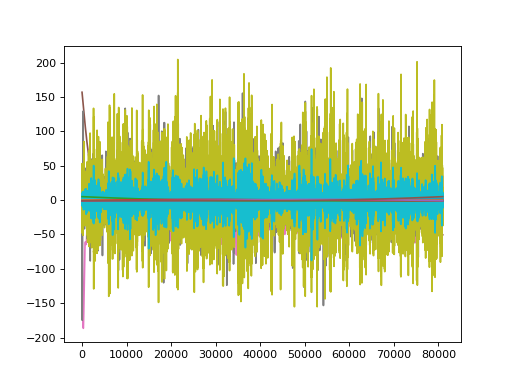

<IPython.core.display.Javascript object>


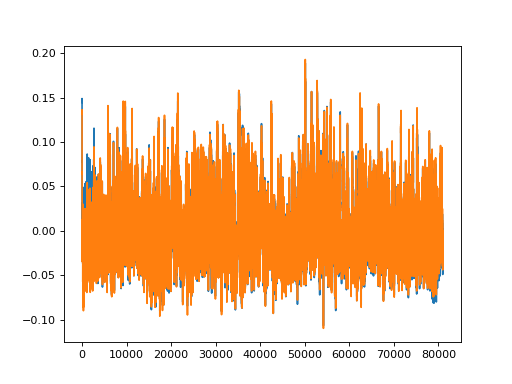

In [46]:
%matplotlib notebook

plt.figure()
plt.plot(sigs.T);

plt.figure()
plt.plot(sigs[:5].sum(0))
plt.plot(dFoF_mean - dFoF_mean.mean())

In [47]:
v1_orth, EVR, EVR_total, pca_dict = similarity.orthogonalize((dFoF - dFoF_mean).T, sigs.T, method='OLS', device=device)

dFoF_orth = v1_orth.T - np.percentile(v1_orth.T, params['dFoF']['percentile_baseline'], axis=1)[:,None]

print(f"Total variance ratio in dFoF orthogonalized out: {EVR_total :.4f}")

Total variance ratio in dFoF orthogonalized out: 0.0869


In [48]:
results['preorthogonalization'] = {}

results['preorthogonalization']['signals'] = sigs
results['preorthogonalization']['EVR_total'] = EVR_total
results['preorthogonalization']['dFoF_mean'] = dFoF_mean
results['preorthogonalization']['Fneu_mean'] = Fneu_mean

In [49]:
import rastermap

In [50]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [51]:
X = dFoF_orth.copy()
# X = dFoF_orth / np.std(dFoF_orth, axis=1, keepdims=True)
# X = timeSeries.simple_smooth(X, sig=4, axis=1)
rmap.fit(X)

nmin 200
0.18350934982299805
5.8852856159210205
6.121625661849976
6.128607749938965
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.00s     0        0.0810      2
0.02s    10        0.1778      4
0.05s    20        0.2040      8
0.07s    30        0.2536      18
0.09s    40        0.2971      28
0.12s    50        0.3380      38
0.15s    60        0.3383      38
0.17s   final      0.3392
0.17s upsampled    0.3392


<IPython.core.display.Javascript object>


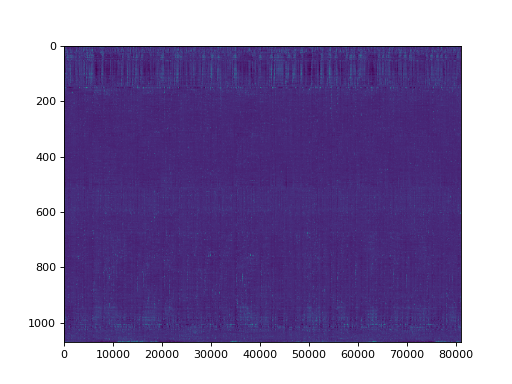

In [52]:
%matplotlib notebook

plt.figure()
plt.imshow(X[rmap.isort], aspect='auto', vmin=-0.2, vmax=2)

In [61]:
params['rank'] = 6

params['spca'] = {}
# params['spca']['alphas'] = [10, 20, 40, 60, 100]
# params['spca']['alphas'] = [20, 40, 60,]
params['spca']['alphas'] = [7, 9, 12]

params['spca']['tol_sweep'] = 1e-4
params['spca']['tol_final'] = 1e-6

params['spca']['n_neurons_nonZero_goal'] = dFoF.shape[0] * 0.05
print(f"n_neurons_nonZero_goal: {params['spca']['n_neurons_nonZero_goal']}")

neural_data_toUse = (dFoF_orth - dFoF_orth.mean(1, keepdims=True)).astype(np.float32)

n_neurons_nonZero_goal: 53.5


In [62]:
U, S, V = torch.svd(torch.as_tensor(neural_data_toUse.T, device=device, dtype=torch.float32), some=True)
U, S, V = U.cpu().numpy(), S.cpu().numpy(), V.cpu().numpy()
U, V = sklearn.utils.extmath.svd_flip(U, V)

spca_partials = partial(sklearn.decomposition.SparsePCA, n_components=6, ridge_alpha=0.01, max_iter=1000, method='lars', n_jobs=None, U_init=U, V_init=V, verbose=True, random_state=None)

In [63]:
spcas = {alpha: spca_partials(alpha=alpha, tol=params['spca']['tol_sweep'],) for alpha in params['spca']['alphas']}

[spca.fit(neural_data_toUse.T) for spca in tqdm(spcas.values())];

  0%|          | 0/3 [00:00<?, ?it/s]

[dict_learning] ............
[dict_learning] .....................
[dict_learning] ......................


In [64]:
n_neurons_nonZero = {alpha: (s.components_ != 0).sum(1).mean() for alpha,s in spcas.items()}

idx_alpha_toUse = np.abs((np.array(list(n_neurons_nonZero.values())) - params['spca']['n_neurons_nonZero_goal'])).argmin()

alpha_toUse = list(n_neurons_nonZero.keys())[idx_alpha_toUse]

In [65]:
print('Number of nonzero components for neuron loadings')
print(f"Goal number of nonzero neurons: {params['spca']['n_neurons_nonZero_goal'] :.1f}")
[print(f"alpha: {key}: {val :.1f}") for key,val in n_neurons_nonZero.items()];

Number of nonzero components for neuron loadings
Goal number of nonzero neurons: 53.5
alpha: 7: 67.5
alpha: 9: 47.8
alpha: 12: 28.7


<IPython.core.display.Javascript object>


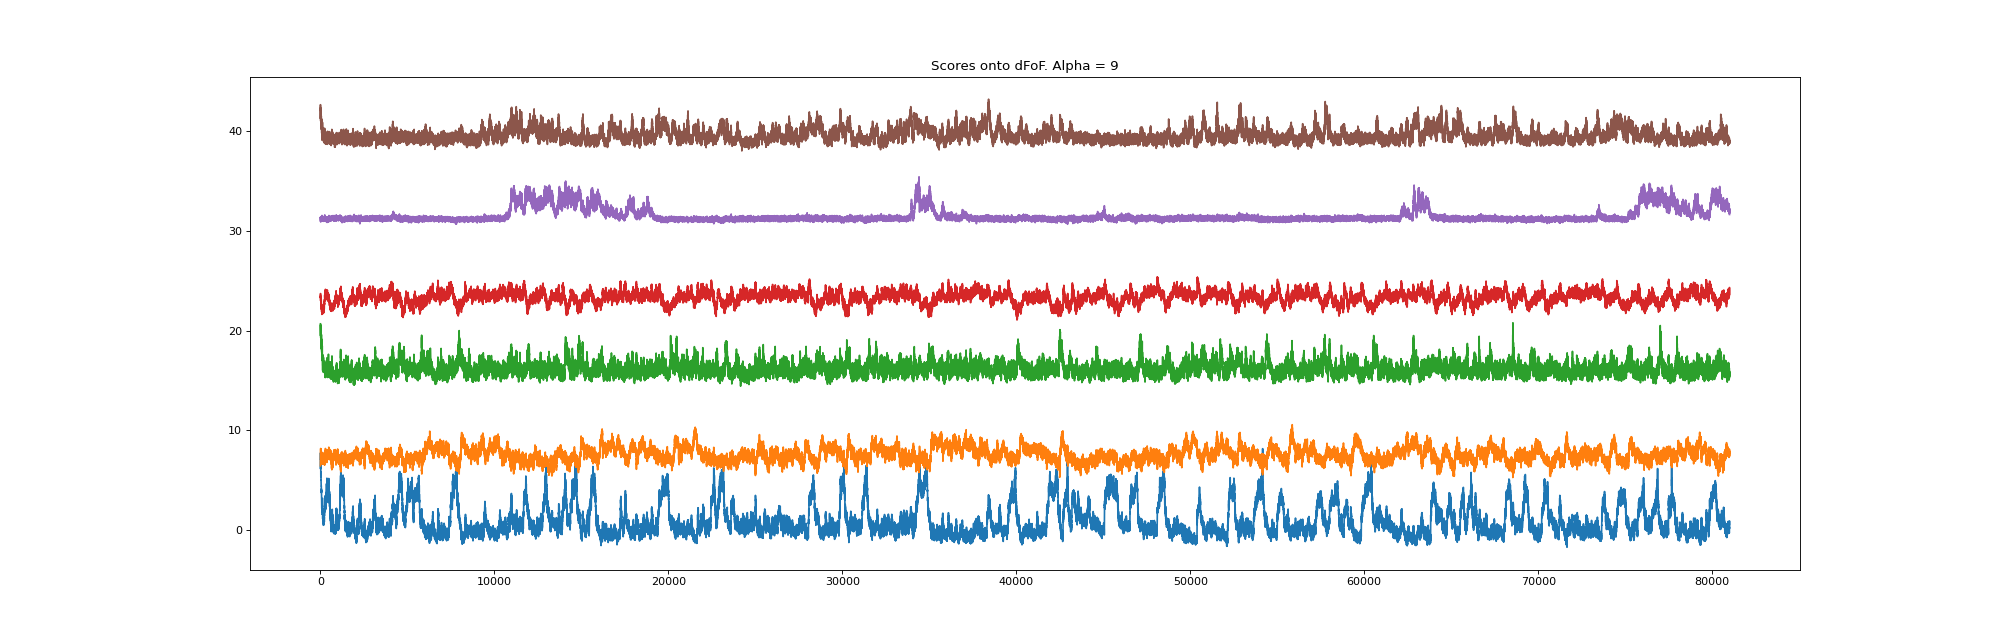

<IPython.core.display.Javascript object>


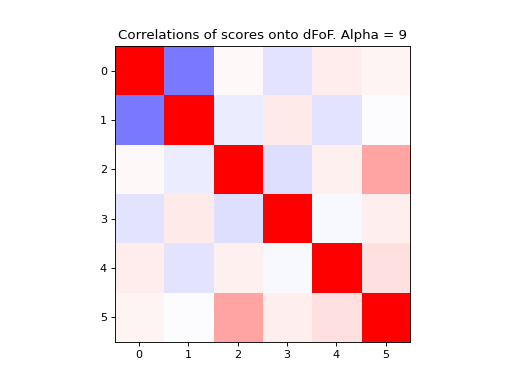

Text(0.5, 1.0, 'Correlations of scores onto dFoF. Alpha = 9')

In [66]:
idx_alpha_toShow = 1

plt.figure(figsize=(25,8))
plt.plot(spcas[params['spca']['alphas'][idx_alpha_toShow]].transform(dFoF.T) + np.arange(params['rank'])*10*spcas[params['spca']['alphas'][idx_alpha_toShow]].transform(dFoF.T).std(1).mean());
plt.title(f"Scores onto dFoF. Alpha = {params['spca']['alphas'][idx_alpha_toShow]}")

plt.figure()
plt.imshow(np.corrcoef(spcas[params['spca']['alphas'][idx_alpha_toShow]].transform(dFoF.T).T), cmap='bwr', vmin=-1, vmax=1);
plt.title(f"Correlations of scores onto dFoF. Alpha = {params['spca']['alphas'][idx_alpha_toShow]}")

In [67]:
print(f"Running final SPCA at a lower tolerance with alpha={alpha_toUse}")
tic = time.time()

spca = spca_partials(alpha=alpha_toUse, tol=params['spca']['tol_final'])
scores = spca.fit_transform(neural_data_toUse.T)

print(f"Duration: {time.time() - tic:.2f}s")

Running final SPCA at a lower tolerance with alpha=9
[dict_learning] .....................
Duration: 18.69s


In [68]:
results['spca'] = {}

results['spca']['alpha_toUse'] = alpha_toUse
results['spca']['objs_alphaSweep'] = {alpha: spca.__dict__ for alpha,spca in spcas.items()}
results['spca']['spca_obj'] = copy.deepcopy(spca.__dict__)
results['spca']['num_nonzero_neurons'] = (spca.components_ != 0).sum(1)

In [69]:
print(f'Number of nonzero components for neuron loadings:')
print(f"Mean: {results['spca']['num_nonzero_neurons'].mean() :.1f}")
print(f"Components: {results['spca']['num_nonzero_neurons']}")

Number of nonzero components for neuron loadings:
Mean: 47.8
Components: [122  81  21  49   4  10]


<IPython.core.display.Javascript object>


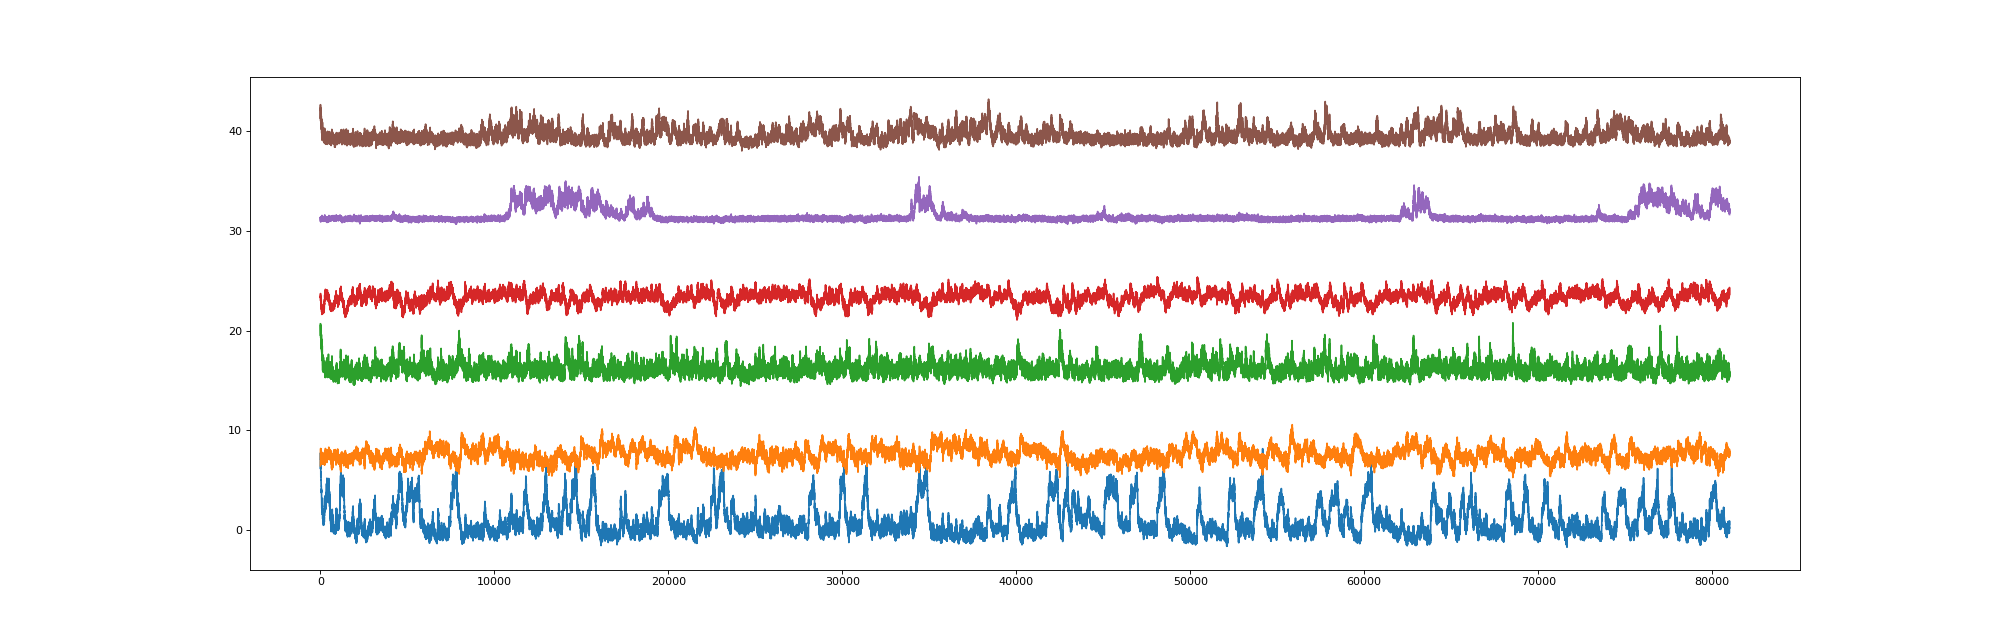

<IPython.core.display.Javascript object>


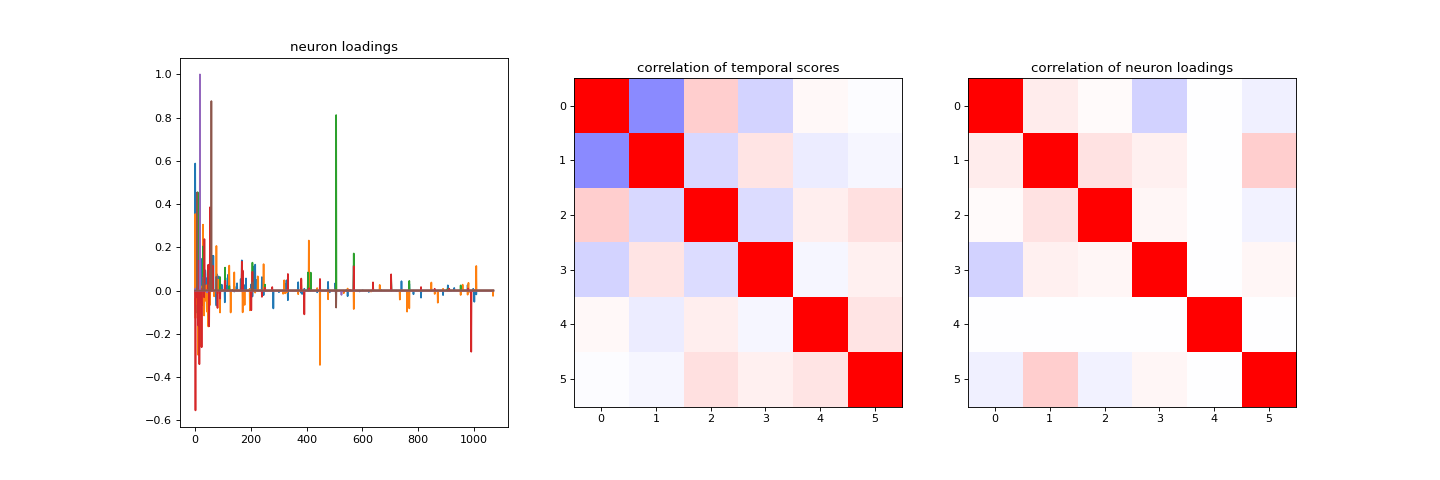

Text(0.5, 1.0, 'correlation of neuron loadings')

In [70]:
plt.figure(figsize=(25,8))
plt.plot(spca.transform(dFoF.T) + np.arange(params['rank'])*10*spca.transform(dFoF.T).std(1).mean());

fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].plot(results['spca']['spca_obj']['components_'].T);
axs[0].set_title('neuron loadings')
axs[1].imshow(np.corrcoef(scores.T), cmap='bwr', vmin=-1, vmax=1)
axs[1].set_title('correlation of temporal scores')
axs[2].imshow(np.corrcoef(results['spca']['spca_obj']['components_']), cmap='bwr', vmin=-1, vmax=1)
axs[2].set_title('correlation of neuron loadings')

<IPython.core.display.Javascript object>


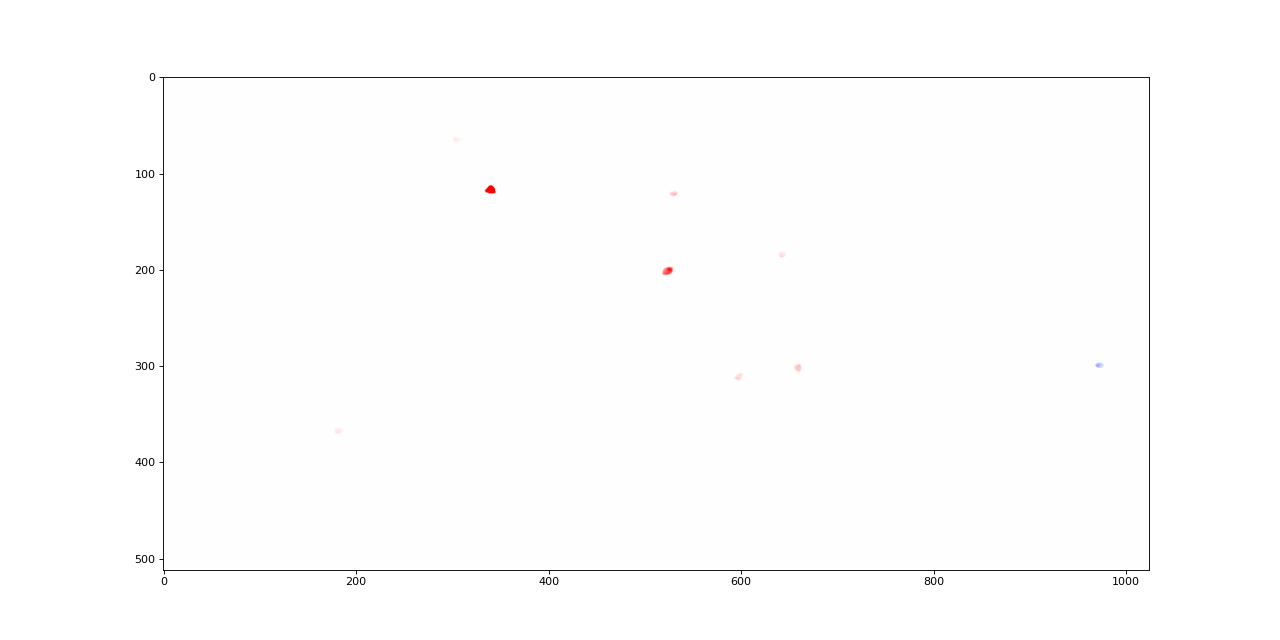

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

In [71]:
weights = results['spca']['spca_obj']['components_'].copy()
sf_weights = (sf[iscell].T * weights.T).T.reshape(params['rank'], data_rois.FOV_height, data_rois.FOV_width)

%matplotlib notebook
fig, ax = plt.subplots(figsize=(16,8))
roicat.visualization.display_toggle_image_stack(
    sf_weights, 
    clim=[-sf_weights.max()/4, sf_weights.max()/4],
    fig=fig,
    ax=ax,
    cmap='bwr',
)

In [72]:
factors_original = results['spca']['spca_obj']['components_'].copy()  ## shape (n_components, n_neurons)

In [73]:
scores_original = (neural_data_toUse.T @ factors_original.T).T  ## shape (n_components, n_timepoints)

In [74]:
factors_regressed, scores_regressed, bias = linear_regression.Ridge(neural_data_toUse.T, scores_original.T, lam=1*10**6, add_bias_terms=True)
factors_regressed = factors_regressed.T
scores_regressed = scores_regressed.T

In [75]:
factors_orth = bmi_idap.helpers.orthogonalize_matrix(factors_regressed)  ## shape (n_components, n_neurons)

In [76]:
scores_orth = (neural_data_toUse.T @ factors_orth.T).T  ## shape (n_components, n_timepoints)

In [77]:
factors_orth_ms = factors_orth - factors_orth.mean(1, keepdims=True)  ## shape (n_components, n_neurons)

In [78]:
factors_orth_ms_norm = factors_orth_ms / factors_orth_ms.std(1, keepdims=True)  ## shape (n_components, n_neurons)
scores_orth_ms_norm_raw = (dFoF.T @ factors_orth_ms_norm.T).T  ## shape (n_components, n_timepoints)

In [79]:
_, order = bmi_idap.helpers.order_factors_by_EVR(scores_orth_ms_norm_raw, dFoF, device=device)  

In [80]:
factors_orth_ms_norm_ordered = factors_orth_ms_norm[order]
scores_orth_ms_norm_raw_ordered = (neural_data_toUse.T @ factors_orth_ms_norm_ordered.T).T  ## shape (n_components, n_timepoints)

In [81]:
factors_final = np.concatenate([factors_orth_ms_norm_ordered, (np.ones(factors_orth_ms_norm_ordered.shape[1]))[None,:]], axis=0)
scores_final = (dFoF.T @ factors_final.T).T  ## shape (n_components, n_timepoints)

In [82]:
results['factors'] = {}

results['factors']['factors_original'] = factors_original
results['factors']['factors_regressed'] = factors_regressed
results['factors']['factors_orth'] = factors_orth
results['factors']['factors_orth_ms'] = factors_orth_ms
results['factors']['factors_orth_ms_norm'] = factors_orth_ms_norm
results['factors']['factors_orth_ms_norm_ordered'] = factors_orth_ms_norm_ordered
results['factors']['factors_final'] = factors_final

results['factors']['scores_original'] = scores_original
results['factors']['scores_regressed'] = scores_regressed
results['factors']['scores_orth'] = scores_orth
results['factors']['scores_orth_ms_norm_raw'] = scores_orth_ms_norm_raw
results['factors']['scores_orth_ms_norm_raw_ordered'] = scores_orth_ms_norm_raw_ordered
results['factors']['scores_final'] = scores_final


<IPython.core.display.Javascript object>


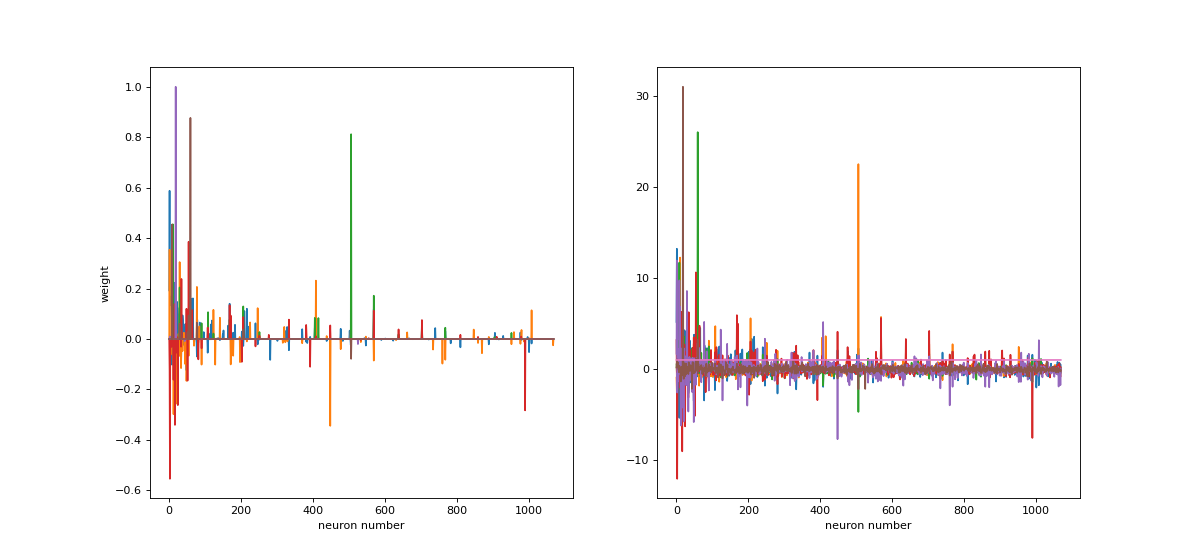

In [83]:
fig, axs = plt.subplots(1,2, figsize=(15, 7), sharex=True)
axs[0].plot(factors_original.T)
axs[0].set_ylabel('weight')
axs[0].set_xlabel('neuron number')
axs[1].plot(factors_final.T)
axs[1].set_xlabel('neuron number');

<IPython.core.display.Javascript object>


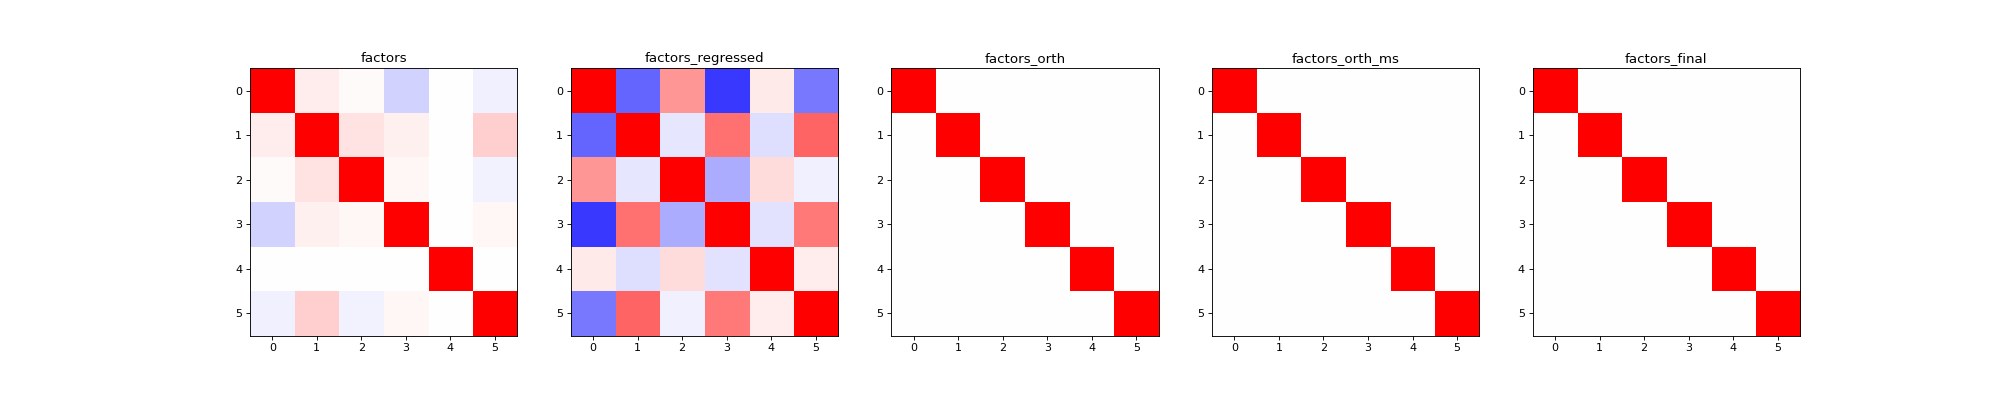

In [84]:
fig, axs = plt.subplots(1, 5, figsize=(25,5))
axs[0].imshow(np.corrcoef(factors_original), cmap='bwr', clim=[-1,1])
axs[0].set_title('factors')
axs[1].imshow(np.corrcoef(factors_regressed), cmap='bwr', clim=[-1,1])
axs[1].set_title('factors_regressed')
axs[2].imshow(np.corrcoef(factors_orth), cmap='bwr', clim=[-1,1])
axs[2].set_title('factors_orth')
axs[3].imshow(np.corrcoef(factors_orth_ms), cmap='bwr', clim=[-1,1])
axs[3].set_title('factors_orth_ms')
axs[4].imshow(np.corrcoef(factors_final[:-1]), cmap='bwr', clim=[-1,1])
axs[4].set_title('factors_final');

<IPython.core.display.Javascript object>


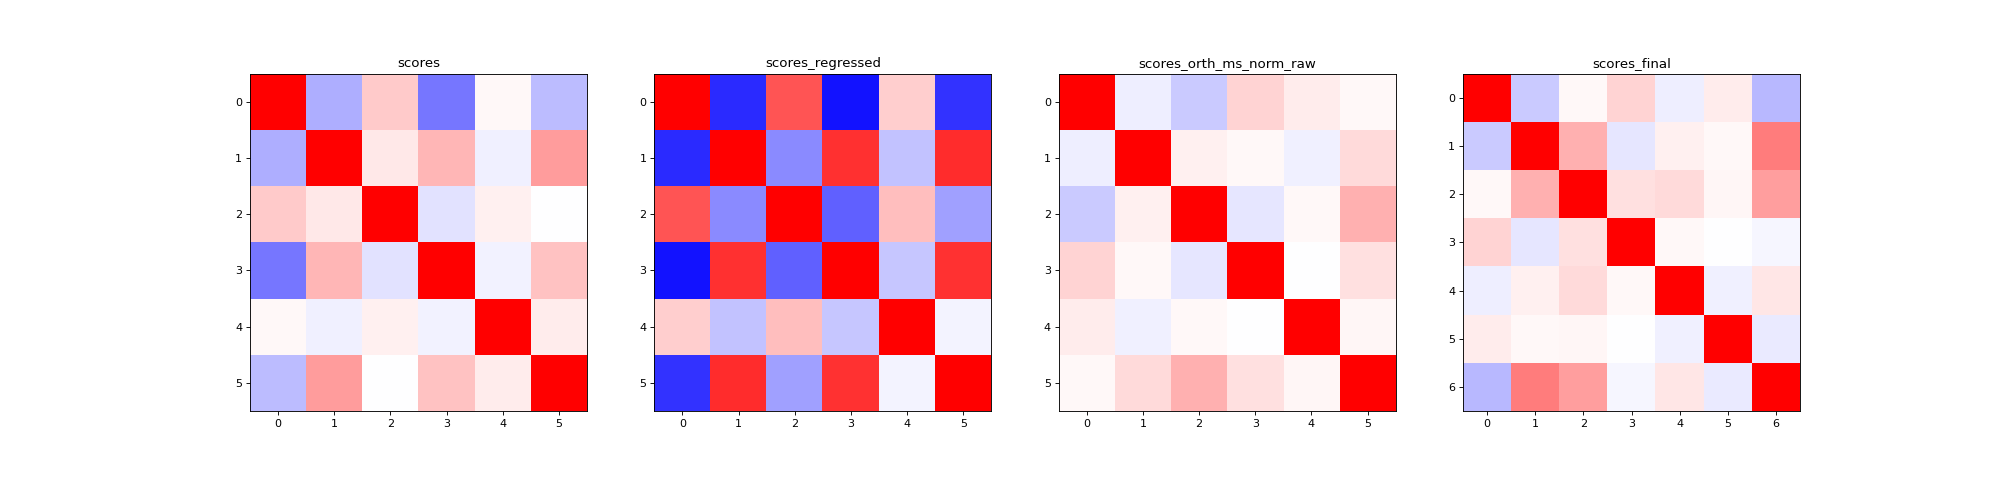

Text(0.5, 1.0, 'scores_final')

In [85]:
fig, axs = plt.subplots(1, 4, figsize=(25,6))
axs[0].imshow(np.corrcoef(scores_original), cmap='bwr', clim=[-1,1])
axs[0].set_title('scores')
axs[1].imshow(np.corrcoef(scores_regressed), cmap='bwr', clim=[-1,1])
axs[1].set_title('scores_regressed')
axs[2].imshow(np.corrcoef(scores_orth_ms_norm_raw), cmap='bwr', clim=[-1,1])
axs[2].set_title('scores_orth_ms_norm_raw')
axs[3].imshow(np.corrcoef(scores_final), cmap='bwr', clim=[-1,1])
axs[3].set_title('scores_final')


<IPython.core.display.Javascript object>


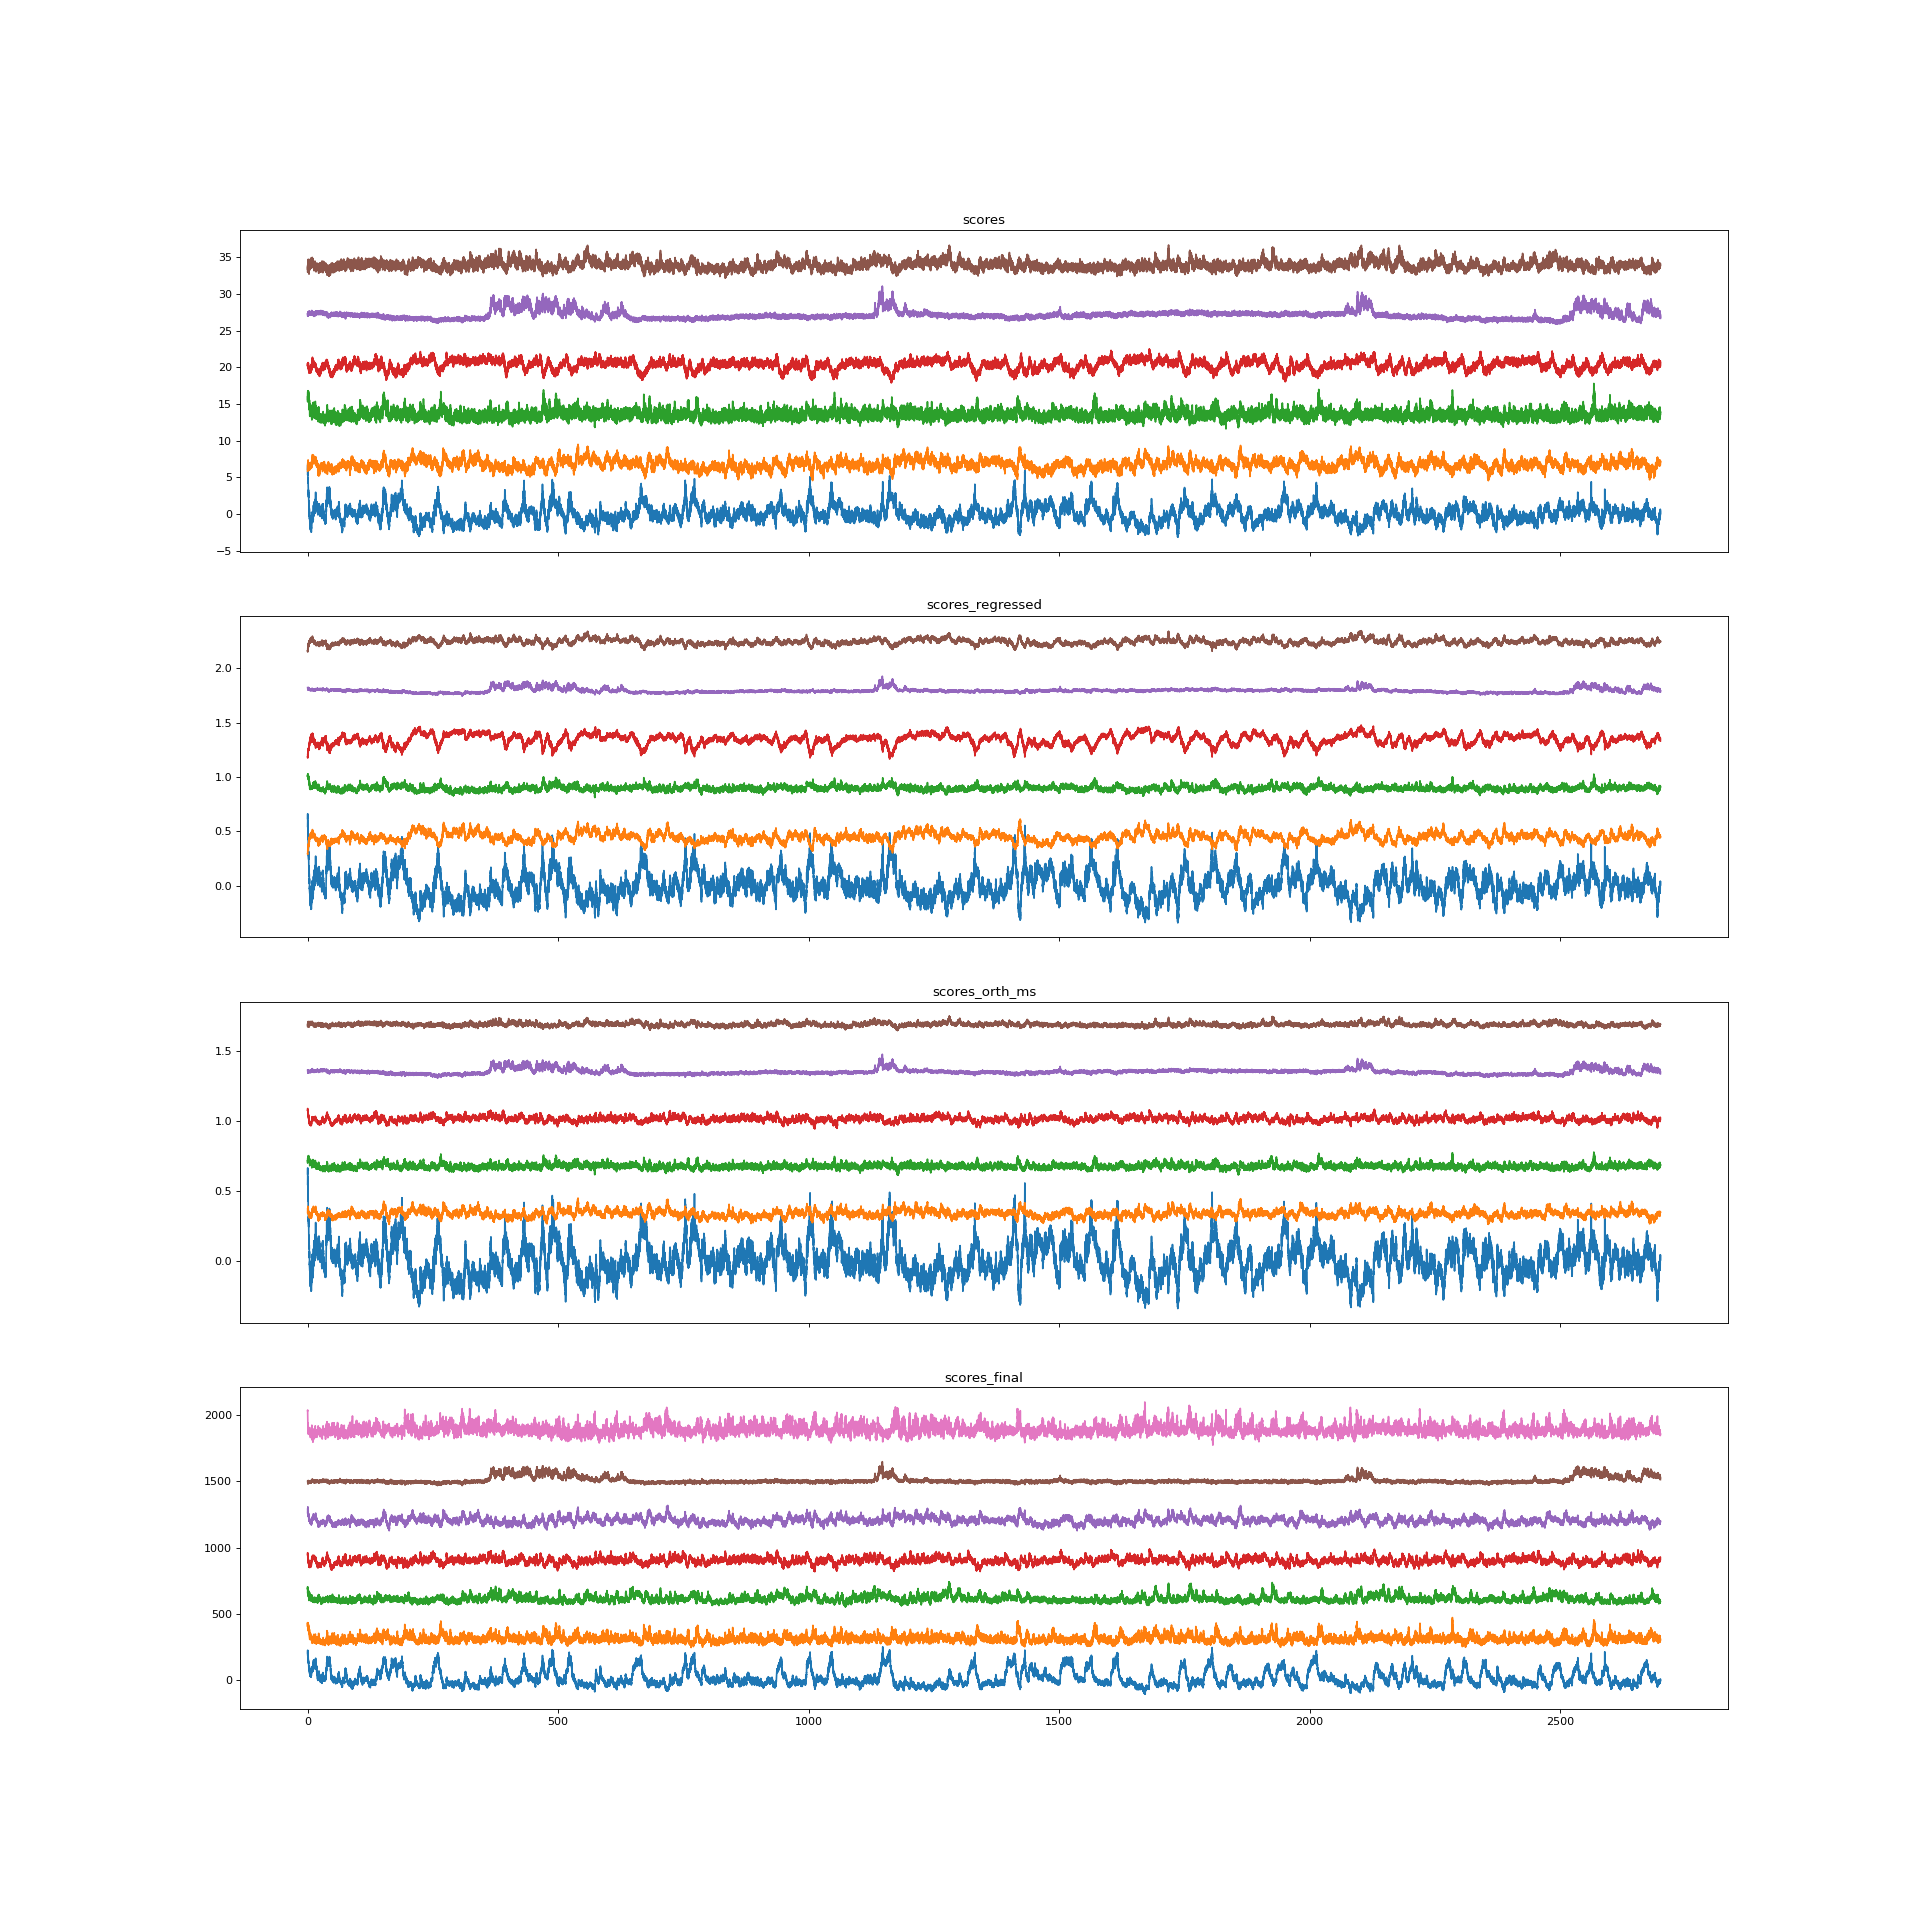

Text(0.5, 1.0, 'scores_final')

In [86]:
fig, axs = plt.subplots(4, 1, figsize=(24,24), sharex=True)
axs[0].plot(np.arange(scores_original.shape[1])/Fs,  scores_original.T + 10*scores_original.std(1).mean()*np.arange(params['rank'])[None,:]);
axs[0].set_title('scores')
axs[1].plot(np.arange(scores_original.shape[1])/Fs,  scores_regressed.T + 10*scores_regressed.std(1).mean()*np.arange(params['rank'])[None,:]);
axs[1].set_title('scores_regressed')
axs[2].plot(np.arange(scores_original.shape[1])/Fs,  scores_orth.T + 10*scores_orth.std(1).mean()*np.arange(params['rank'])[None,:]);
axs[2].set_title('scores_orth_ms')
axs[3].plot(np.arange(scores_original.shape[1])/Fs,  scores_final.T + 10*scores_final.std(1).mean()*(np.arange(params['rank']+1))[None,:]);
axs[3].set_title('scores_final')


<IPython.core.display.Javascript object>


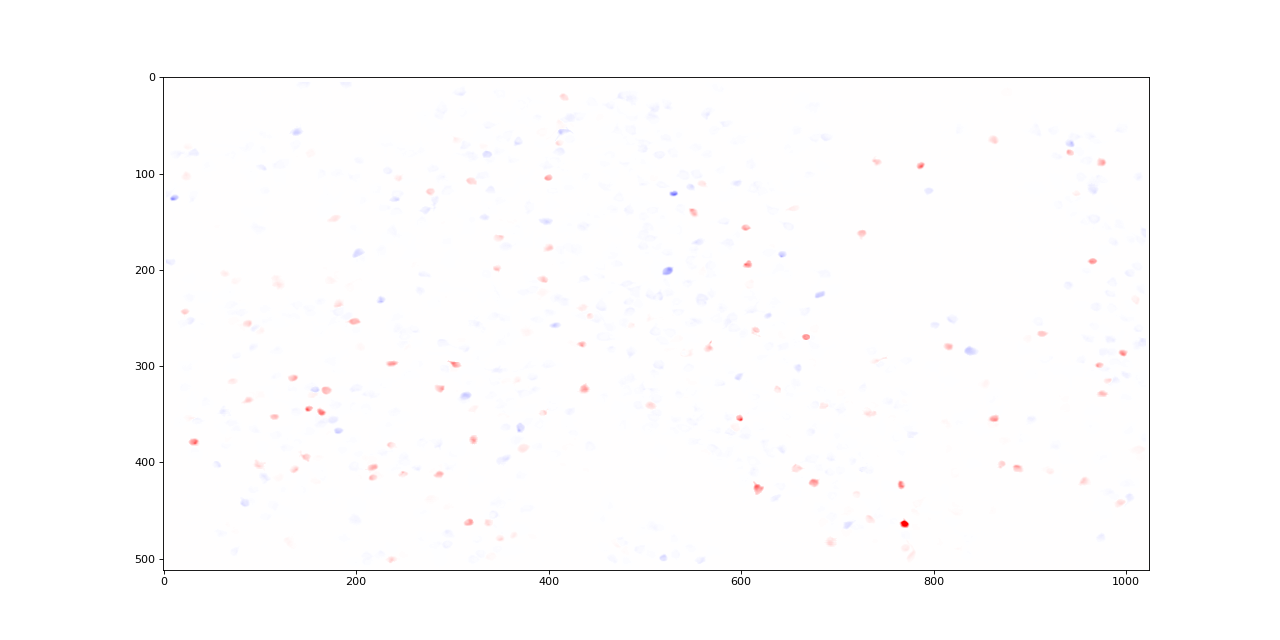

interactive(children=(IntSlider(value=0, description='i_frame', max=6), Output()), _dom_classes=('widget-inter…

In [87]:
weights = factors_final.copy()
sf_weights = (sf[iscell].T * weights.T).T.reshape(weights.shape[0], data_rois.FOV_height, data_rois.FOV_width)

%matplotlib notebook
fig, ax = plt.subplots(figsize=(16,8))
roicat.visualization.display_toggle_image_stack(
    sf_weights, 
    clim=[-1*sf_weights.max()/4, sf_weights.max()/4],
    fig=fig,
    ax=ax,
    cmap='bwr',
)

In [88]:
def make_evr_power_curve(factors, data, powers=[0, 1, 2, 3, 5, 10], device='cpu'):
    decoder = bmi_idap.decoder.Decoder_angle_magnitude(
        F=factors.T,
        device=device
    )
    
    Ds = [decoder(X=data, power=p)[0] for p in powers]
    
    evrs = [similarity.orthogonalize(data.T, d.T, device=device, method='OLS')[2] for d in tqdm(Ds)]
    
    return evrs

In [89]:
components_pca, scores_pca, singVals_pca, EVR_pca = decomposition.torch_pca(neural_data_toUse.T, mean_sub=True, device=device, return_numpy=True)

In [90]:
vals_power = np.concatenate([[0], math_functions.bounded_logspace(0.1, 100, 30)])

# evrs = [make_evr_power_curve(f, neural_data_toUse, powers=vals_power, device=device) for f in [components_pca.T[:params['rank']], factors_orth_ms_ordered_norm]]
evrs = [make_evr_power_curve(f, dFoF, powers=vals_power, device=device) for f in [components_pca.T[:params['rank']], factors_final[:-1]]]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


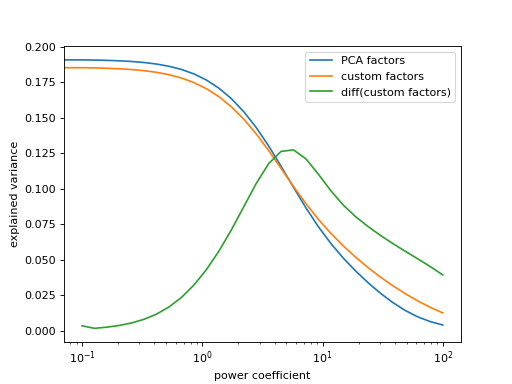

In [91]:
plt.figure()
plt.plot(vals_power, evrs[0])
plt.plot(vals_power, evrs[1])
plt.plot(vals_power[1:], np.diff(evrs[1])*-10)

plt.ylabel('explained variance')
plt.xlabel('power coefficient')
plt.xscale('log')
plt.legend(['PCA factors', 'custom factors', 'diff(custom factors)'])
# plt.ylim([0, 0.5])

In [93]:
results['manifold_alignment'] = {}

results['manifold_alignment']['components_pca'] = components_pca
results['manifold_alignment']['vals_power'] = vals_power
results['manifold_alignment']['evrs_pca'] = evrs[0]
results['manifold_alignment']['evrs_factors'] = evrs[1]

In [100]:
params['simulation'] = {}

params['simulation']['power'] = 2.0
params['simulation']['idx_factor'] = 0
params['simulation']['idx_avg'] = -1
params['simulation']['thresh_reward'] = 2.0
params['simulation']['thresh_quiescence_cursor'] = 0.2 * params['simulation']['thresh_reward']
params['simulation']['duration_quiescence_hold'] = 3
params['simulation']['duration_threshold_hold'] = 3
params['simulation']['win_smooth_cursor'] = 3

In [101]:
decoder = bmi_idap.decoder.Decoder_angle_magnitude(
    F=results['factors']['factors_final'].T,
    device=device,
    power=params['simulation']['power'],
)

D, CS, M = decoder(dFoF)

In [102]:
params['simulation']['ptile_quiescence_avgVec'] = 0.8
params['simulation']['thresh_quiescence_avgVec'] = torch.quantile(CS[-1], q=params['simulation']['ptile_quiescence_avgVec'])

In [103]:
num_rewards, sm = bmi_idap.decoder.simple_cursor_simulation(
    D.T, 
    CS.T, 
    idx_cursor=params['simulation']['idx_factor'], 
    idx_avg=params['simulation']['idx_avg'], 
    thresh_reward=params['simulation']['thresh_reward'], 
    thresh_quiescence_avgVec=params['simulation']['thresh_quiescence_avgVec'], 
    thresh_quiescence_cursor=params['simulation']['thresh_quiescence_cursor'], 
    duration_quiescence_hold=params['simulation']['duration_quiescence_hold'],
    duration_threshold_hold=params['simulation']['duration_threshold_hold'],
    win_smooth_cursor=params['simulation']['win_smooth_cursor'],
)


 33%|████████████████████████▍                                                 | 26729/81000 [00:06<00:14, 3726.86it/s]


 65%|████████████████████████████████████████████████▏                         | 52744/81000 [00:13<00:07, 3698.96it/s]


 95%|██████████████████████████████████████████████████████████████████████▍   | 77151/81000 [00:20<00:01, 3735.83it/s]


100%|██████████████████████████████████████████████████████████████████████████| 81000/81000 [00:21<00:00, 3768.11it/s]


In [104]:
rewards_per_min = num_rewards / (D.shape[1] / (Fs*60*1))

print(f"Rewards per minute: {rewards_per_min :.3f}")

Rewards per minute: 0.800


<IPython.core.display.Javascript object>


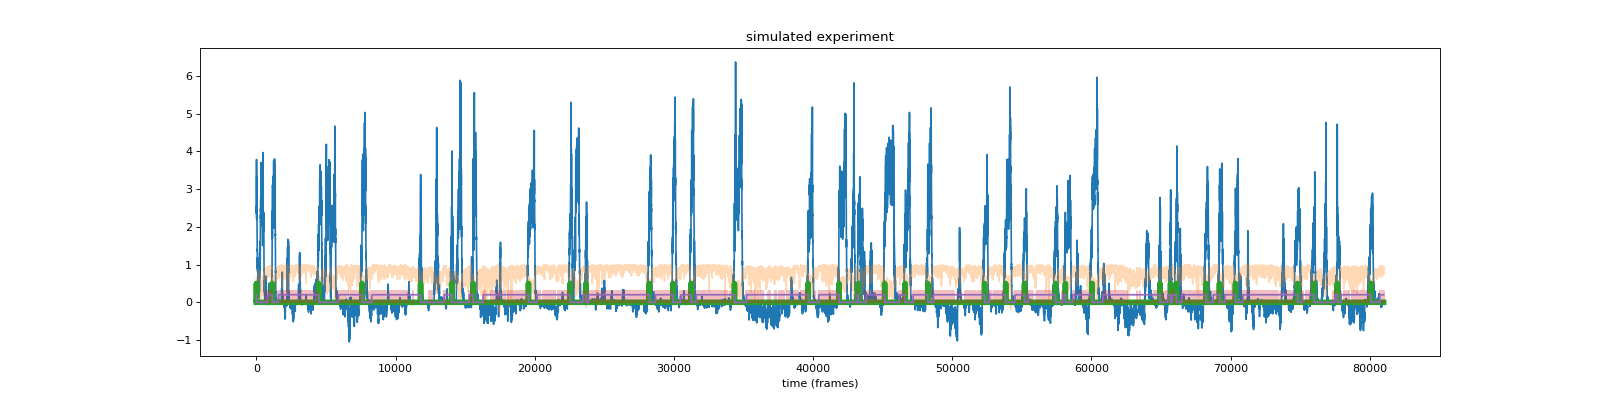

In [105]:
plt.figure(figsize=(20,5))
plt.plot(sm['cursor'])
plt.plot(sm['timeSeries_avgVec'], alpha=0.3)
plt.plot(sm['rewards']*0.5, linewidth=5)
plt.plot(sm['CS_quiescence']*0.3, alpha=0.3)
plt.plot(sm['CE_trial']*0.2)
plt.title('simulated experiment')
plt.xlabel('time (frames)');

In [106]:
results['simulation'] = {}

results['simulation']['idx_factor'] = params['simulation']['idx_factor']
results['simulation']['D'] = D
results['simulation']['CS'] = CS
results['simulation']['M'] = M
results['simulation']['num_rewards'] = num_rewards
results['simulation']['rewards_per_min'] = rewards_per_min
results['simulation']['sm'] = sm

<IPython.core.display.Javascript object>


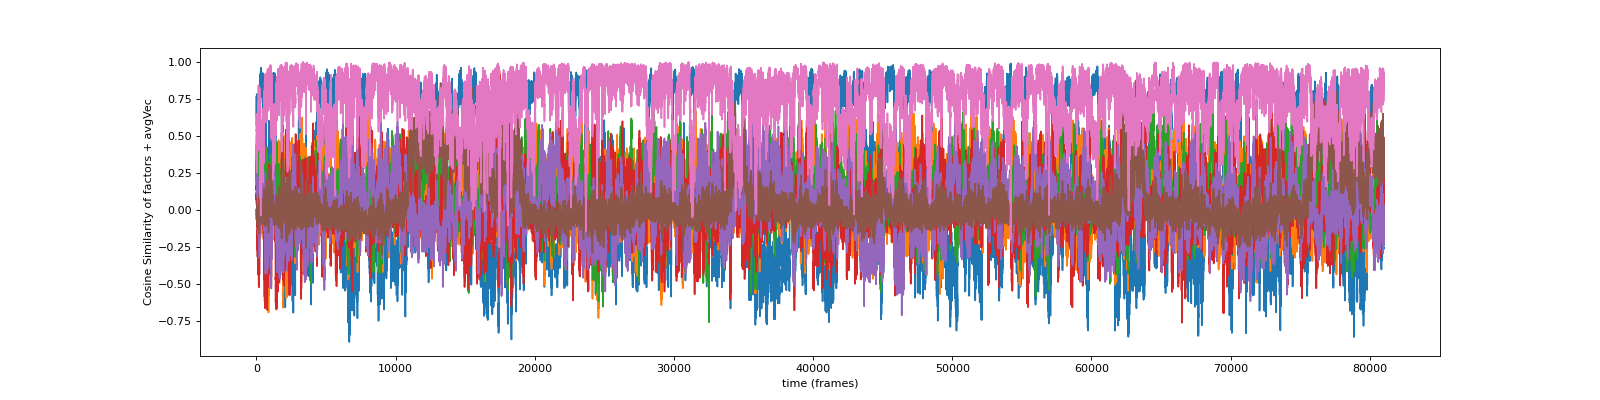

In [107]:
plt.figure(figsize=(20,5))
plt.plot(CS.T.cpu());
plt.xlabel('time (frames)')
plt.ylabel('Cosine Similarity of factors + avgVec');

<IPython.core.display.Javascript object>


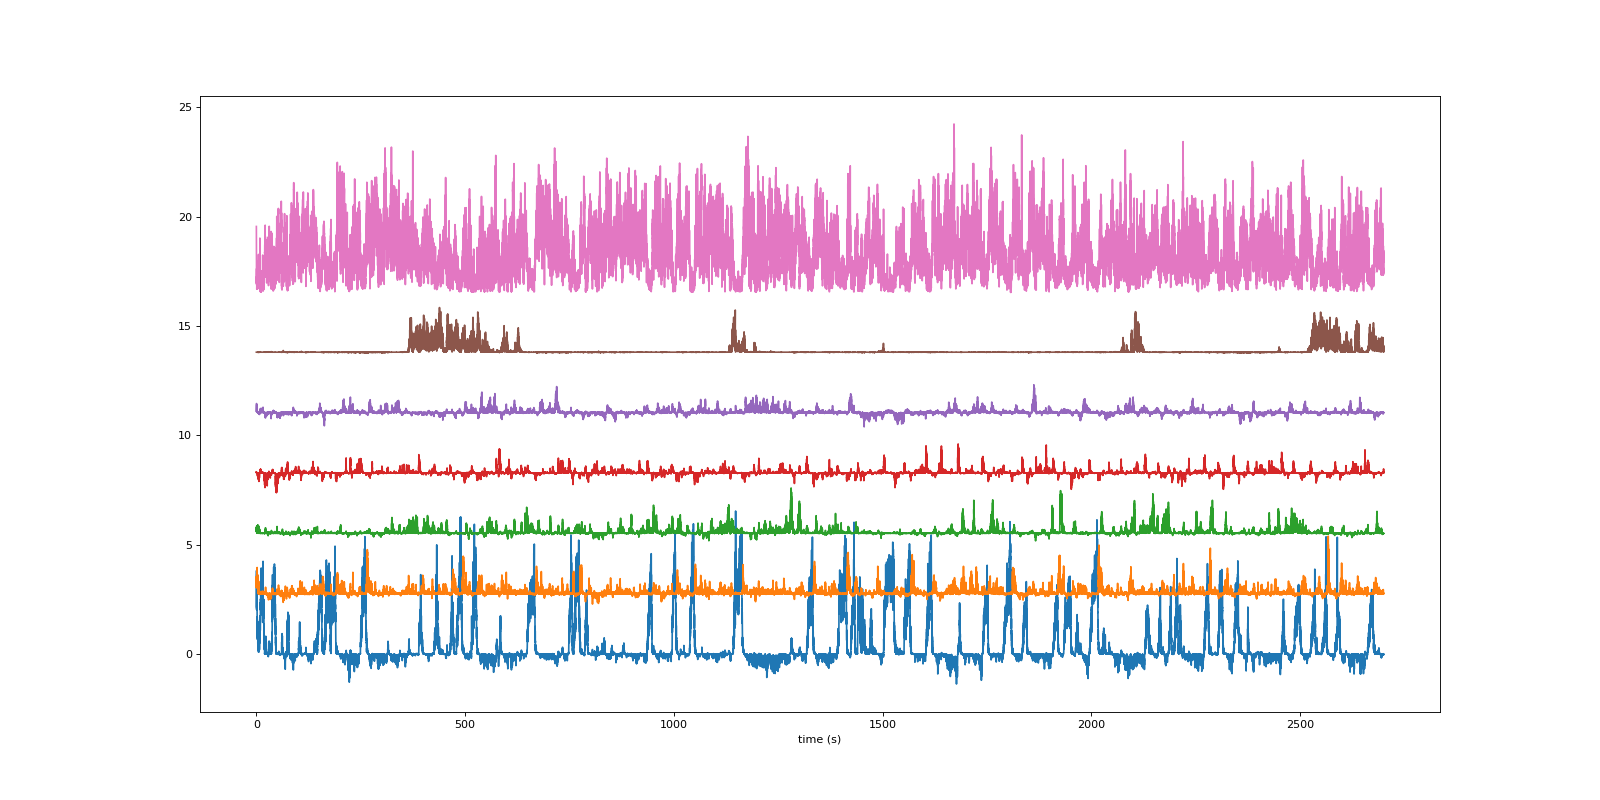

In [108]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(D.shape[1])/Fs, (D.cpu() + torch.arange(D.shape[0])[:,None]*D.std(1).mean().cpu()*7).T)
plt.xlabel('time (s)');

<IPython.core.display.Javascript object>


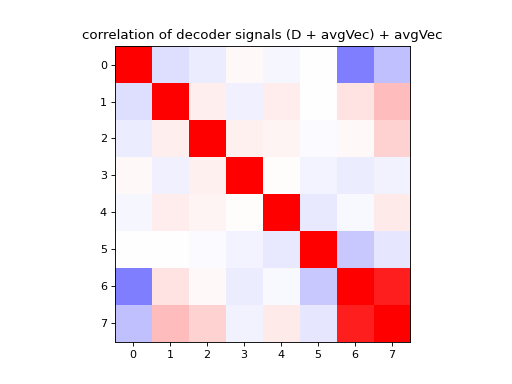

In [110]:
plt.figure()
plt.imshow(
    np.corrcoef(np.concatenate(
        (D.cpu(), dFoF_mean[None,:]), axis=0   
    )), vmin=-1, vmax=1, cmap='bwr'
);
plt.title('correlation of decoder signals (D + avgVec) + avgVec');

visualization of final traces and masks

# Save it all

In [111]:
weights_day0 = {
    "factors" : results['factors']['factors_final'],
    "iscell_custom": results['data']['iscell'],
    "spatialFootprints": results['data']['spatialFootprints'],
}

scipy.io.savemat(str(Path(params['paths']['path_save_weights']).with_suffix('.mat')) , weights_day0)
np.save(str(Path(params['paths']['path_save_weights']).with_suffix('.npy')) , weights_day0)


file_helpers.pickle_save(
    obj={'results': results, 'params': params},
    path_save=str(Path(params['paths']['path_save_results']).with_suffix('.pkl')),
)